In [1]:
from pprint import pprint
import os, json

# Read results files

In [2]:
# # assumes we're in {app}-{version}/ with 
# # {system_name}-{compute_instance_type}/{compiler_family}-{mpi_family}/runs/{run_label/}run.json
# #
# # could probably do with abstracting this out - everything will need it!

# # TODO: simplify this - e.g. just pull out path name then split that into lables

# def fs_tree(root='.'):
#     """ Return a nested dict of the filetree below `root`.
    
#         Directory names are represented as keys.
#         File names are available under the key "./".
#     """
#     results = {}
#     for (dirpath, dirnames, filenames) in os.walk(root):
#         # in-place filter of dirnames to avoid hidden directories:
#         for idx, d in enumerate(dirnames):
#             if d.startswith('.'):
#                 del dirnames[idx]
#         parts = dirpath.split(os.sep)
#         if parts[0] == '.':
#             parts = parts[1:]
#         curr = results
#         for p in parts:
#             curr = curr.setdefault(p, {'./':filenames})
#     return results

# TODO: function to separate path names into lables:
#          'system_name'
#                 'compute_instance_type'
#                 'compiler_family'
#                 'mpi_family'
#                 'run_label'
#                 'filename'
#                    fpath = os.path.join(* parts + ['runs', rundir, runfile])
#                     lables = {'system_name':parts[0].split('-')[0],
#                               'compute_instance_type':parts[0].split('-')[1],
#                               'compiler_family':parts[1].split('-')[0],
#                               'mpi_family':parts[1].split('-')[1],
#                               'run_label':rundir,
#                               'filename':runfile,
#                              }

def find_run_outputs(root='.', ext='.out'):
    """ Find files with a given extension within any run directory.
    
        TODO: change so it searches *below* run directories (or build/, benchmarks/ etc)
        Returns a sequence of paths.
    """
    results = []
    for (dirpath, dirnames, filenames) in os.walk(root):
        # in-place filter dirnames to avoid hidden directories:
        for idx, d in enumerate(dirnames):
            if d.startswith('.'):
                del dirnames[idx]
        for f in filenames:
            if os.path.splitext(f)[-1] == ext:
                pathparts = [root] + dirpath.split(os.path.sep) + [f]
                # if it's a run output then path is ".../runs/{run_label}/{filename}
                if pathparts[-3] == 'runs':
                    fullpath = os.path.normpath(os.path.join(*pathparts))
                    results.append(fullpath)
    return(results)
                
run_outs = find_run_outputs()
print run_outs

['sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-13.out', 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-14.out', 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-15.out', 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-16.out']


In [3]:
def read_imb_out(path):
    results = {'file':path}
    COL_TYPES = {'Uniband':(int, int, float, int),
                 'Biband':(int, int, float, int),
                }
    with open(path) as f:
        for line in f:
            if line.startswith('# Benchmarking '):
                benchmark = line.split()[-1]
                processes = next(f).split()[-1] # "# #processes = 2"
                result = {'name':benchmark, 'data':{}, 'params':{'processes':processes}}
                results[benchmark] = result
                next(f) # skip header
                while True:
                    cols = next(f).split()
                    if cols == []:
                        break
                    if cols[0].startswith('#'): # header row
                        header = cols
                        for label in header:
                            result['data'][label] = []
                    else:
                        for label, opr, value in zip(header, COL_TYPES[benchmark], cols):
                            result['data'][label].append(opr(value))
    return results

results = []
for path in run_outs:
    print 'read', path
    results.append(read_imb_out(path))
    


read sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-13.out
read sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-14.out
read sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-15.out
read sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-16.out


In [4]:
pprint(results)

[{'file': 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-13.out'},
 {'file': 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-14.out'},
 {'file': 'sausage-hotdog/gnu8-openmpi3/runs/N2npn1/slurm-15.out'},
 {'Biband': {'data': {'#bytes': [0,
                                 1,
                                 2,
                                 4,
                                 8,
                                 16,
                                 32,
                                 64,
                                 128,
                                 256,
                                 512,
                                 1024,
                                 2048,
                                 4096,
                                 8192,
                                 16384,
                                 32768,
                                 65536,
                                 131072,
                                 262144,
                                 

In [27]:
# get metadata
def get_metadata(path): # from any path inside a run dir
    
    # find "master" dir:
    MARKER_DIRS = ('builds', 'runs', 'benchmarks')
    parts = os.path.abspath(path).split(os.path.sep)
    marker_dirs = dict((name, parts.index(name)) for name in MARKER_DIRS if name in parts)
    if len(marker_dirs) > 1:
        raise ValueError('%s found in path %s; only expected one of these' % (path, marker_dirs.keys()))
    master_dir_idx = marker_dirs.values()[0] - 1
    master_dir = os.path.sep.join(parts[:master_dir_idx + 1])
    
    # find ".../runs/{run_id}/" dir
    if 'runs' not in marker_dirs:
        raise ValueError('"runs" directory not found in path %' % path)
    run_dir = os.path.sep.join(parts[:marker_dirs['runs'] + 2])
    run_label = os.path.basename(run_dir)
    
    # read run config:
    config = {}
    run_cfg = os.path.join(run_dir, 'run.json')
    if not os.path.exists(run_cfg):
        raise ValueError('run config %s not found' % run_cfg)
    with open(run_cfg) as run_f:
        config['run'] = json.load(run_f)
    
    # read build config
    build_label = config['run'].get('build', None)
    if build_label is None:
        raise ValueError('key "build" not found in run config %s' % run_cfg)
    build_cfg = os.path.join(master_dir, 'builds', build_label, 'build.json')
    if not os.path.exists(build_cfg):
        raise ValueError('build config %s not found' % build_cfg)
    with open(build_cfg) as build_f:
        config['build'] = json.load(build_f)
    
    return config
    

slurm16_path = run_outs[-1]
slurm16_meta = get_metadata(slurm16_path)
pprint(slurm16_meta)
# Note this isn't actually used yet ...

{'build': {u'modules': {u'compiler': u'gnu8/8.3.0',
                        u'mpi': u'openmpi3/3.1.4',
                        u'other': [u'imb/2018.1']},
           u'version': u'2018.1'},
 'run': {u'build': u'initial',
         u'mpirun': [u'--mca btl_base_warn_component_unused 0'],
         u'sbatch': {u'--nodes': 2, u'--ntasks-per-node': 1}}}


['Uniband', 'Biband', 'file']


Text(0,0.5,'Mbytes/sec')

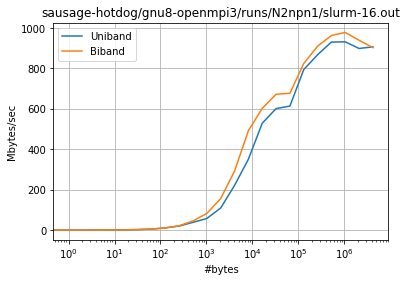

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
print slurm16.keys()
slurm16 = results[-1]
for case in slurm16: # e.g. Uniband
    if case == 'file': # TODO: be nice to get rid of this!
        continue
    data = slurm16[case]['data']
    plt.plot(data['#bytes'], data['Mbytes/sec'], label=case)
plt.grid()
plt.title(slurm16['file'])
plt.legend()
plt.xscale('log')
plt.xlabel('#bytes')
plt.ylabel('Mbytes/sec')